Análisis de frecuencia de palabras según subtítulos de videos (ejecutar primero subs_to_matrix.py para generar los archivos necesarios)

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Set, Dict, Tuple, Callable

# tokens_freq contains total frequency for each token
# file_texts contains for each file a dictionary where the keys are the tokens present in the file and the values are the frequence
TokenDict = Dict[str, float]
FileDict = Dict[str, Dict[str, int]]

data = 'data/'
with open(data + 'tokens_freq.json') as tokens_file:
  tokens_freq: TokenDict = { k: float(v) for k, v in json.load(tokens_file).items()}
with open(data + 'file_texts.json') as files_file:
  file_texts: FileDict = json.load(files_file)

# vids_l contains duration in hours for each video
vids_l: Dict[str, float] = {}
for f in file_texts:
    with open('CleanSubs/' + f) as f_subs:
        vlen = list(f_subs)[-1].split(',')[1].split(':')
        if(len(vlen) == 3):
            vids_l[f] = float(vlen[0]) + float(vlen[1])/60 + float(vlen[2])/(60*60)

Definición de funciones auxiliares para la visualización

In [2]:
def filter_words_by_freq(d: TokenDict, freq: int) -> Tuple[TokenDict, TokenDict]:
    '''Filter words from word dict d that have frequency lower than freq'''
    filtered = dict()
    remaining = dict()
    for k, v in d.items():
        if v >= freq:
            remaining[k] = v
        else:
            filtered[k] = v
    return remaining, filtered

def filter_files_by_words(files: FileDict, filtered_words: TokenDict) -> Tuple[FileDict, FileDict]:
    '''Filter files which contain words in filtered_words'''
    remaining: FileDict = {}
    filtered: FileDict = {}
    for t, f in files.items():
        for word in filtered_words:
            if word in f:
                filtered[t] = f
                break
        if not filtered.get(t, False):
            remaining[t] = f
    return remaining, filtered

def filtered_to_perc(rf: Tuple[List[dict], List[dict]]) -> float:
    '''Gets a tuple of (remaining, filtered) and returns percent of remaining over total'''
    return 100 * len(rf[1]) / (len(rf[0]) + len(rf[1]))

def total_time(vids: List[str], vids_l: Dict[str, float]) -> float:
    '''Returns for list of videos the total length acording to lengths stored in vids_l'''
    return sum(map(lambda f: vids_l.get(f, 0), vids))

def total_token_freq(file_texts: FileDict) -> TokenDict:
    '''Given a FileDict generates a dictionary of frequency for each token in files'''
    tokens_freq: TokenDict = {}
    for f in file_texts.values():
        for token in f:
            tokens_freq[token] = tokens_freq.get(token, 0) + f[token]
    return tokens_freq

def gen_words_by_limits(file_texts: FileDict, lims: Tuple[int, int]) -> Tuple[List[int], List[int], List[int]]:
    '''Generates tuple contains 3 lists corresponding to the ammount of tokens according to each frequency lims[i] in each video'''
    words_by_limits: Tuple[List[int], List[int], List[int]] = tuple([0 for _ in file_texts.keys()] for i in range(3))
    for i, (f, words) in enumerate(file_texts.items()):
        for word in words:
            words_by_limits[0 if tokens_freq[word] < lims[0] else 1 if tokens_freq[word] < lims[1] else 2][i] += 1
    return words_by_limits

def gen_stacked_and_perc_df(file_texts: FileDict, lims: Tuple[int, int]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    wbls = gen_words_by_limits(file_texts, lims)
    wbls_perc = [[q*100/(wbls[0][i] + wbls[1][i] + wbls[2][i]) for i, q in enumerate(wbl)] for wbl in wbls]
    df_wbls = pd.DataFrame({labels[i]: wbls[i] for i in range(3)}, index=file_texts).sort_values(by=list(labels), ascending=False)
    df_wbls_perc = pd.DataFrame({labels[i]: wbls_perc[i] for i in range(3)}, index=file_texts).sort_values(by=list(labels), ascending=False)
    return df_wbls, df_wbls_perc

Análisis de la frecuencia de aparición de cada token del vocabulario

count    60604.000000
mean        27.470497
std        198.118704
min          1.000000
25%          1.000000
50%          2.000000
75%          8.000000
max      14384.000000
Name: Word Frequency, dtype: float64

si            14384.0
              13792.0
bueno         10989.0
va             9353.0
ver            7256.0
ahora          6821.0
vamos          6555.0
hoy            6312.0
así            5848.0
argentina      5806.0
ser            5717.0
gobierno       5185.0
entonces       5095.0
bien           5079.0
momento        4949.0
dos            4873.0
buenos         4862.0
día            4809.0
puede          4709.0
presidente     4611.0
hace           4585.0
país           4483.0
hacer          4462.0
años           4433.0
decir          4317.0
tener          4203.0
mil            4167.0
situación      4142.0
ciudad         4134.0
días           4054.0
después        4022.0
año            4009.0
personas       3978.0
van            3908.0
tema           3891.0
poder          3864.0
caso           3797.0
justamente     3730.0
salud          3725.0
gente          3717.0
Name: Word Frequency, dtype: float64

/home/pedroodb/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

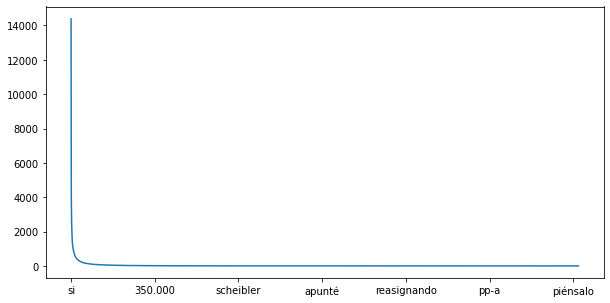

In [3]:
s_word_freqs = pd.Series(tokens_freq, name="Word Frequency").sort_values(ascending=False)
display(s_word_freqs.describe())
display(s_word_freqs.head(40))
display(s_word_freqs.plot(figsize=(10,5)))

Zoom en el gráfico anterior

/home/pedroodb/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

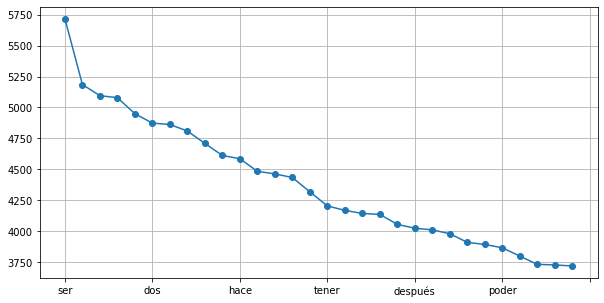

In [4]:
s_word_freqs.iloc[10:40].plot(marker='o', grid=True, figsize=(10,5))

Porcentaje de tokens filtrados sobre el total al variar la frecuencia minima 

count    100.000000
mean      87.456538
std       15.644230
min        0.000000
25%       87.776797
50%       92.530196
75%       94.506138
max       95.696654
Name: Percent of words filtered by frequency, dtype: float64

<AxesSubplot:>

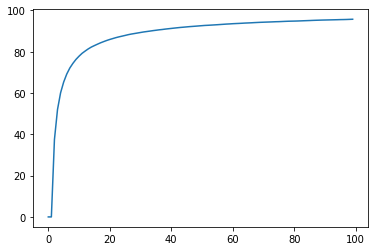

In [5]:
# filtered_words contains list of (remaining, filtered) tokens when filtering by frequency from 0 to 100
filtered_words: List[Tuple[TokenDict, TokenDict]] = [filter_words_by_freq(tokens_freq, i) for i in range(100)]

filtered_word_percents = map(filtered_to_perc, filtered_words)
s_filtered_word_percents = pd.Series(filtered_word_percents, name="Percent of words filtered by frequency")
display(s_filtered_word_percents.describe())
display(s_filtered_word_percents.plot())

Porcentaje de videos filtrados al variar frecuencia mínima para filtrar palabra

count    100.000000
mean      97.735361
std       14.089399
min        0.000000
25%       99.937927
50%       99.958618
75%       99.958618
max       99.958618
Name: Percent of files filtered by frequency, dtype: float64

<AxesSubplot:>

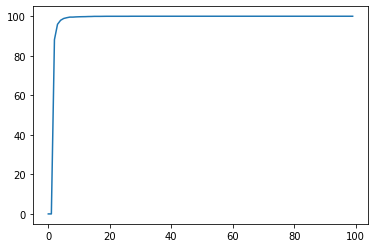

In [6]:
# filtered_words contains list of (remaining, filtered) files dictionaries when filtering by tokens in filtered_words
filtered_files: List[Tuple[TokenDict, TokenDict]] = [filter_files_by_words(file_texts, f_tokens[1]) for f_tokens in filtered_words]

# filtered_files_percents contain percent of each item from filtered_files over total files
filtered_files_percents = map(filtered_to_perc, filtered_files)
s_filtered_files_percent = pd.Series(filtered_files_percents, name="Percent of files filtered by frequency")
display(s_filtered_files_percent.describe())
display(s_filtered_files_percent.plot())

Zoom en el gráfico anterior

<AxesSubplot:>

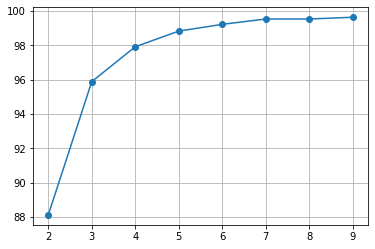

In [7]:
s_filtered_files_percent.iloc[2:10].plot(marker='o', grid=True)

Mismo análisis pero en función del tiempo en lugar del porcentaje

count    100.000000
mean       7.686370
std       51.967832
min        0.000000
25%        0.000000
50%        0.000000
75%        0.008361
max      369.382081
Name: Hours by word frequency filtered, dtype: float64

<AxesSubplot:>

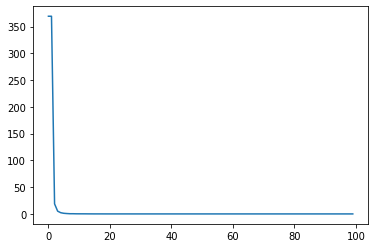

In [8]:
# filtered_files_hours contain length in hours of each item from filtered_files
filtered_files_hours = [total_time(rem.keys(), vids_l) for rem, fil in filtered_files]
s_filtered_files_hours = pd.Series(filtered_files_hours, name="Hours by word frequency filtered")
display(s_filtered_files_hours.describe())
display(s_filtered_files_hours.plot())

Zoom en el gráfico anterior 

<AxesSubplot:>

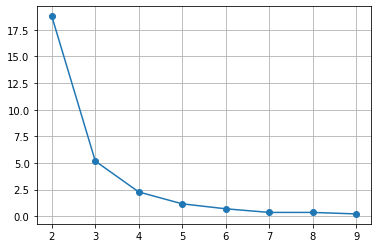

In [9]:
s_filtered_files_hours.iloc[2:10].plot(marker='o', grid=True)

Histograma de frecuencia de palabras en los videos que no contienen palabras con frecuencia menor a FREQ_LIMIT

574 videos with no words with frequency lower than 2


count    12368.000000
mean         6.868370
std         22.610736
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        645.000000
dtype: float64

Mean:  6.86836998706339
Std:  22.610736109851967
/home/pedroodb/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

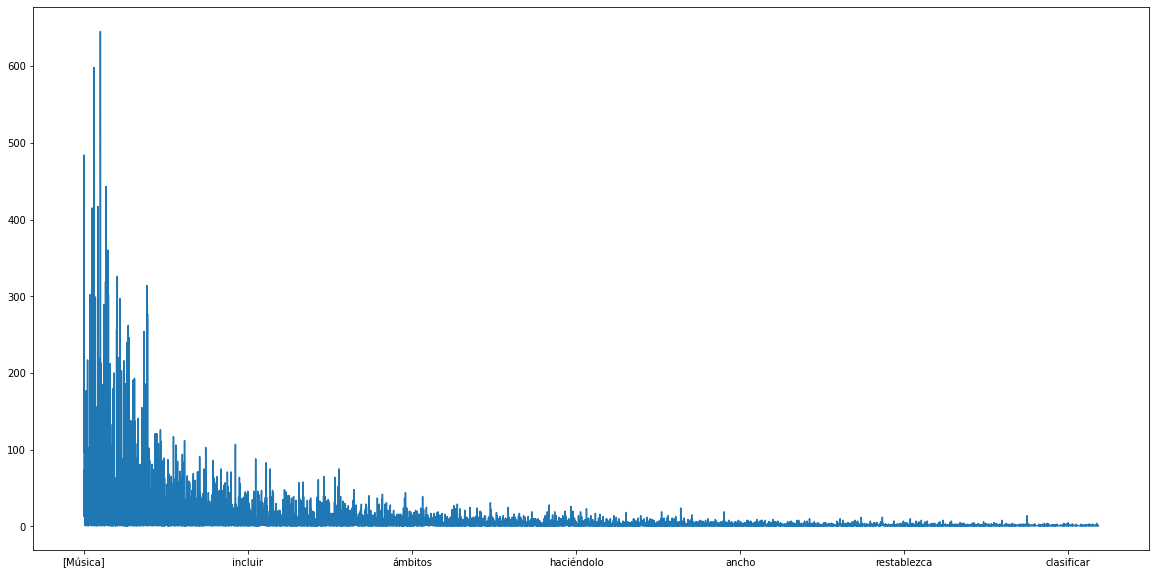

In [10]:
FREQ_LIMIT = 2
f_file_texts: FileDict = filtered_files[FREQ_LIMIT][0]

f_files_freq = total_token_freq(f_file_texts)

print('{} videos with no words with frequency lower than {}'.format(len(f_file_texts), FREQ_LIMIT))

s_f_files_freq = pd.Series(f_files_freq)
display(s_f_files_freq.describe())
print('Mean: ', s_f_files_freq.mean())
print('Std: ', s_f_files_freq.std())
display(s_f_files_freq.plot(figsize=(20,10)))

Gráfico de barras con los videos en el eje x donde se le asocian la cantidad de palabras coloreadas segun su frecuencia. Luego el gráfico se replica pero en función del porcentaje en lugar de la cantidad total.

Showing 50 of 4833 videos


<AxesSubplot:>

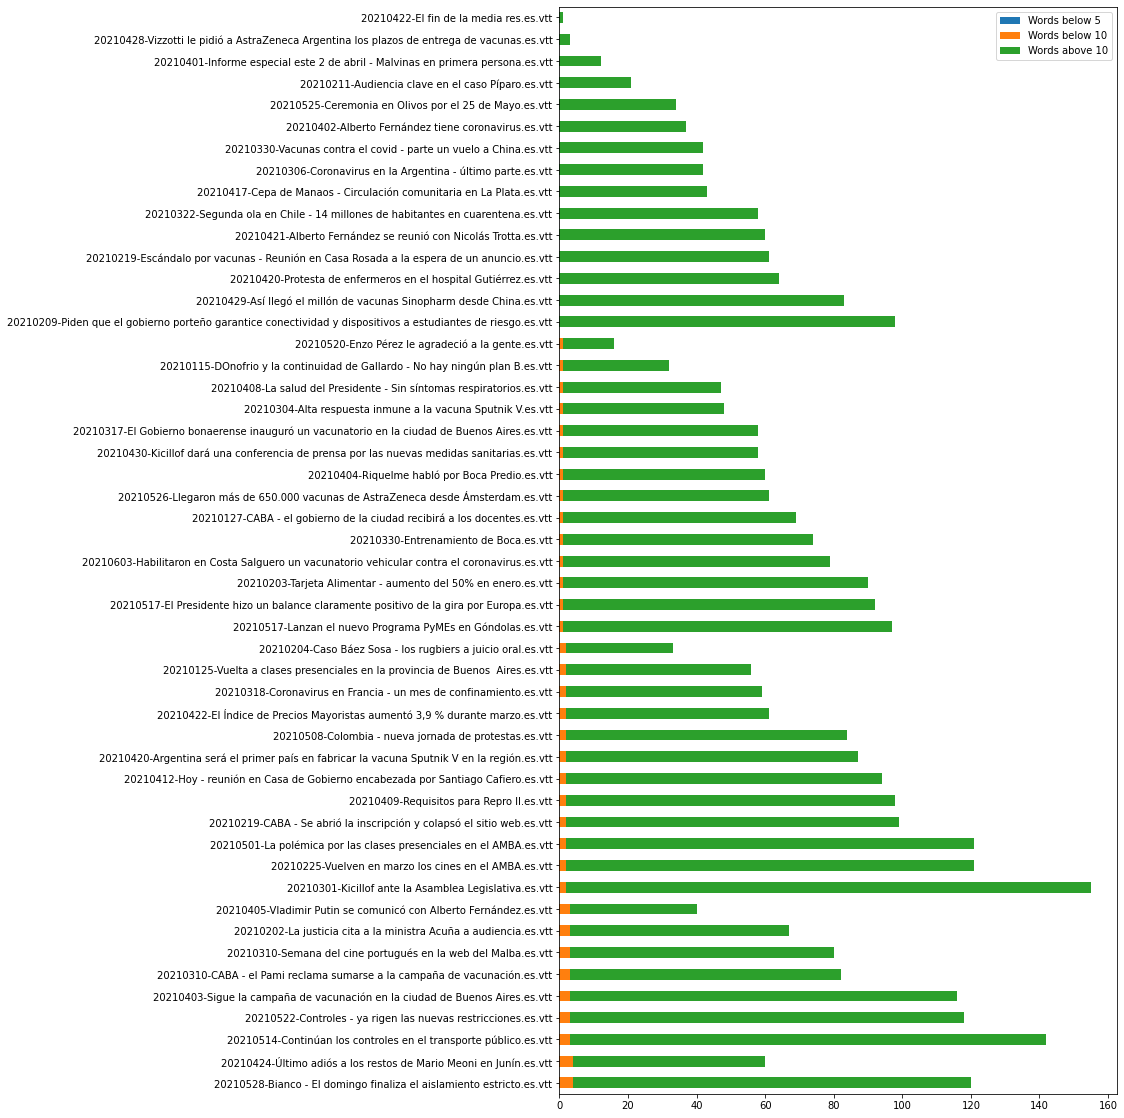

In [11]:
SHOW = 50
LIMS: Tuple[int, int] = (5, 10)
labels: Tuple[str, str, str] = ('Words below {}'.format(LIMS[0]), 'Words below {}'.format(LIMS[1]), 'Words above {}'.format(LIMS[1]))

df_videos_tokens_frequency, df_vtf_percents = gen_stacked_and_perc_df(file_texts, LIMS)

print("Showing {} of {} videos".format(SHOW, len(file_texts)))
df_videos_tokens_frequency.iloc[-SHOW:].plot.barh(stacked=True, figsize=(10,20))

Showing 100 of 4833 videos


<AxesSubplot:>

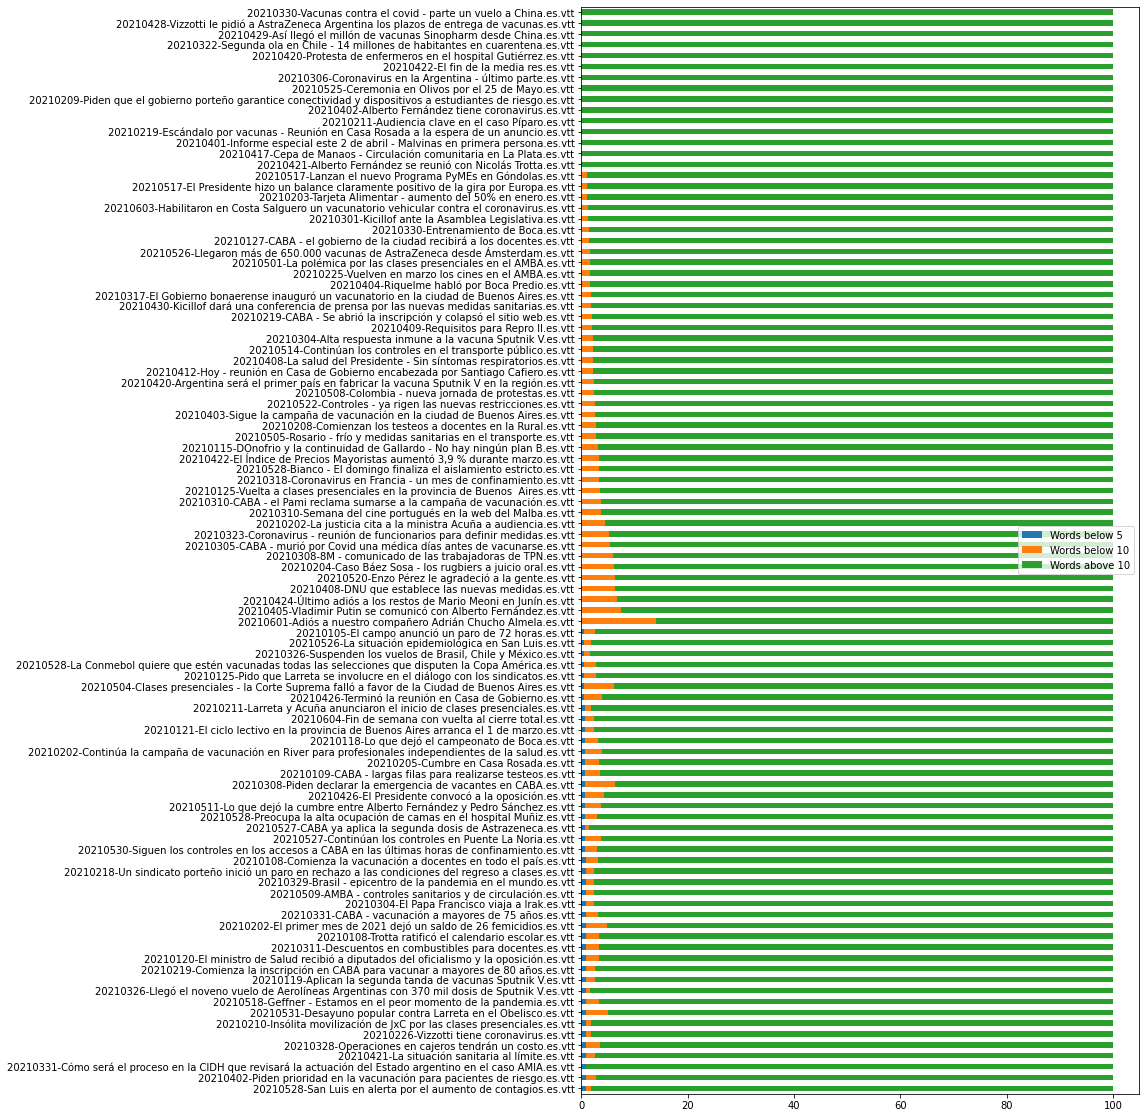

In [12]:
SHOW_P = 100

print("Showing {} of {} videos".format(SHOW_P, len(file_texts)))
df_vtf_percents.iloc[-SHOW_P:].plot.barh(stacked=True, figsize=(10,20))

Mismos gráficos que los anteriores pero ahora tomando los videos que no utilizan palabras con frecuencia menor a FREQ_LIMIT

574 videos restantes, total de 18.774902222222206 horas
Showing 50 of 574 videos


<AxesSubplot:>

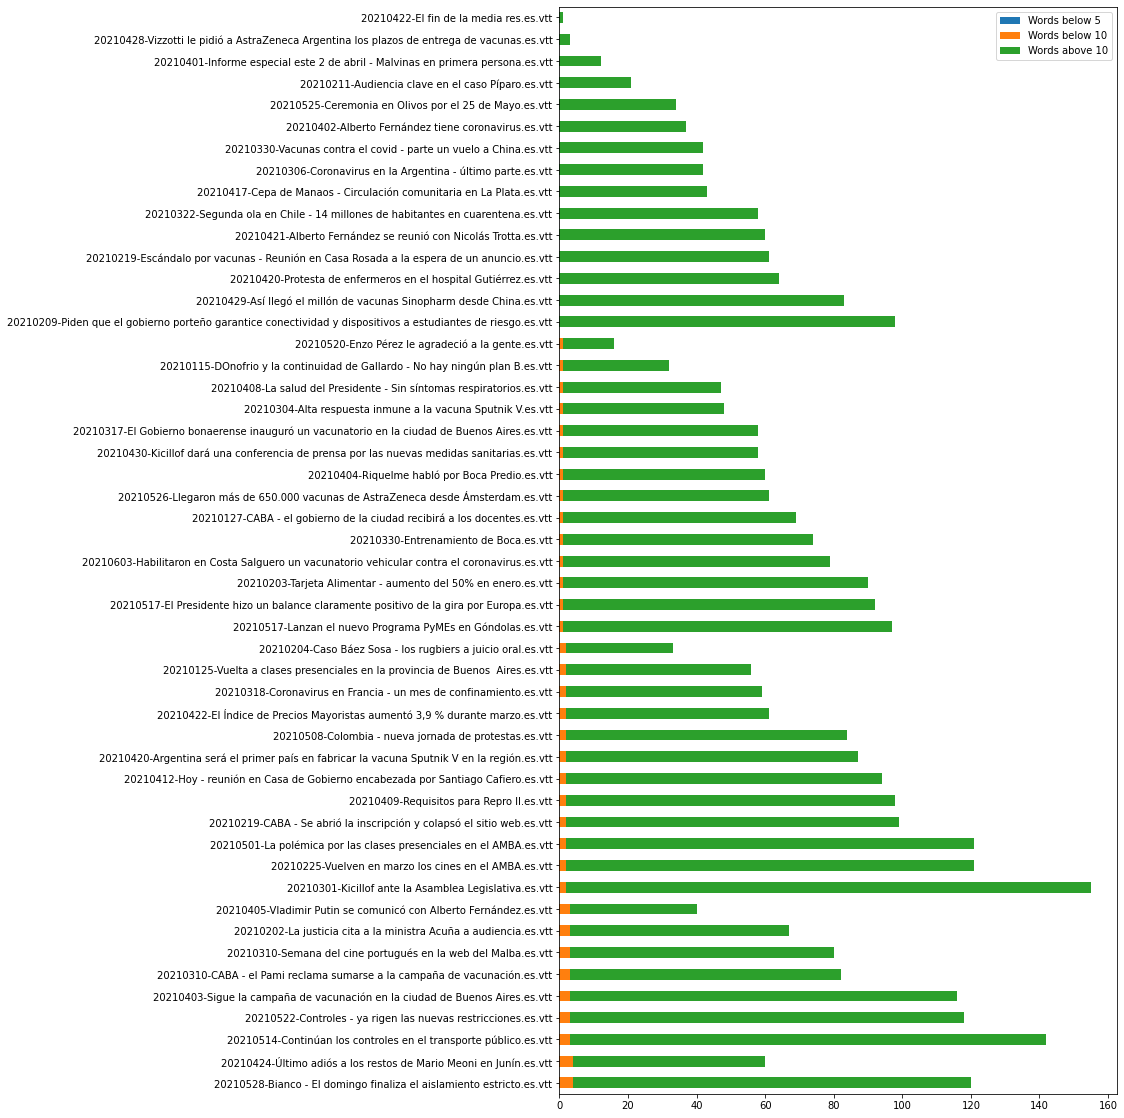

In [13]:
FREQ_LIMIT = 2
f_file_texts: FileDict = filtered_files[FREQ_LIMIT][0]
f_times: Dict[str, float] = {f: vids_l.get(f, 0) for f in f_file_texts.keys()}
print('{} videos restantes, total de {} horas'.format(len(f_file_texts), sum(f_times.values())))

df_f_vtf, df_f_vtf_percents = gen_stacked_and_perc_df(f_file_texts, LIMS)

print("Showing {} of {} videos".format(SHOW, len(f_file_texts)))
df_f_vtf.iloc[-SHOW:].plot.barh(stacked=True, figsize=(10,20))

Showing 100 of 574 videos


<AxesSubplot:>

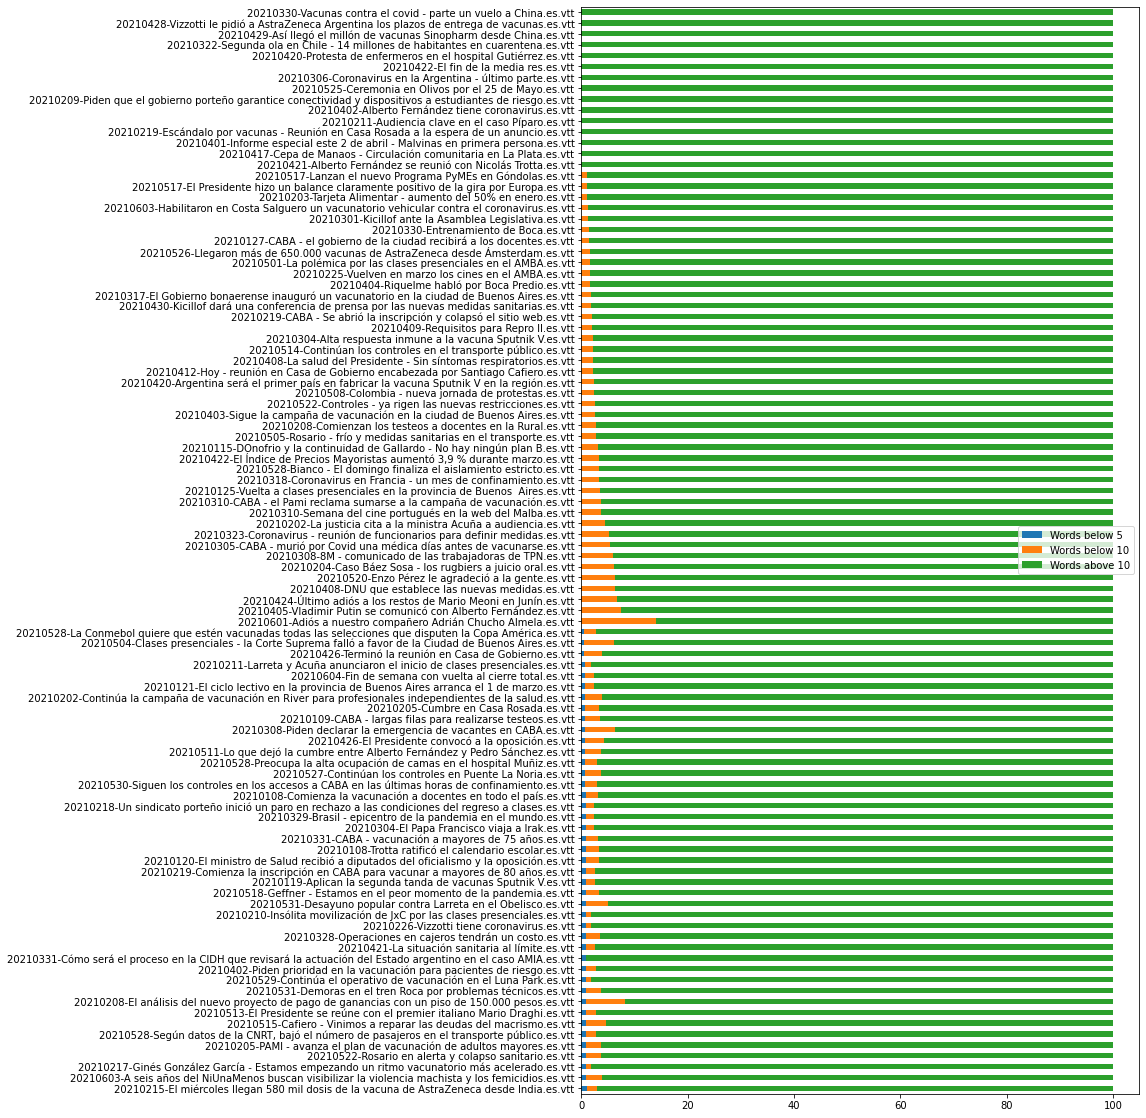

In [14]:
print("Showing {} of {} videos".format(SHOW_P, len(f_file_texts)))
df_f_vtf_percents.iloc[-SHOW_P:].plot.barh(stacked=True, figsize=(10,20))

A continuación se toman las palabras más frecuentes y se filtran los videos en función de los que NO contienen alguna de las las N palabras más frecuentes.

In [15]:
w_index: List[str] = [''] + list(map(lambda p: p[0], list(s_word_freqs.items())[:100]))
w_series: List[float] = []

files_remaining: FileDict = file_texts
for word in w_index:
    w_series.append(total_time(files_remaining, vids_l))
    files_remaining = {t: f for t, f in files_remaining.items() if word in f}

s_hours_by_filtering_words = pd.Series(w_series, index=enumerate(w_index), name="Hours by filtering most frequent words")

s_hours_by_filtering_words.describe()

count    101.000000
mean      27.202181
std       59.247314
min        0.000000
25%        0.000000
50%        0.868481
75%       20.598353
max      369.382081
Name: Hours by filtering most frequent words, dtype: float64

El siguiente gráfico muestra sobre el eje y la cantidad de horas totales de los videos que contienen todas las palabras desde la más frecuente hasta la palabra x (ordenadas por frecuencia)

/home/pedroodb/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

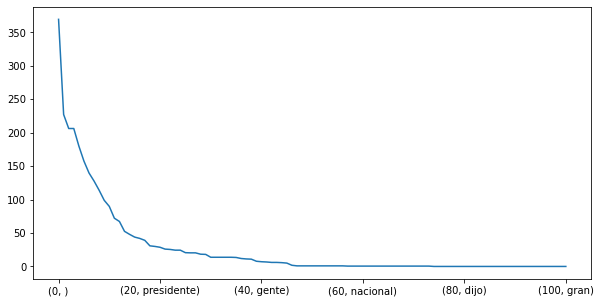

In [16]:
s_hours_by_filtering_words.plot(figsize=(10,5))

/home/pedroodb/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


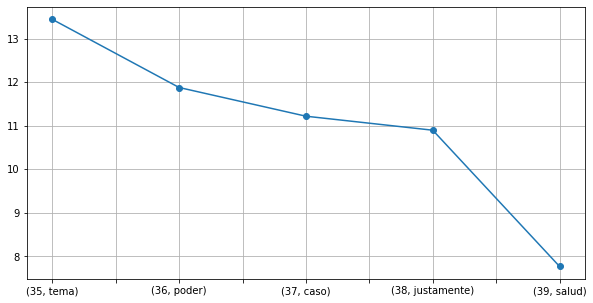

In [17]:
ax = s_hours_by_filtering_words.iloc[35:40].plot(marker='o', grid=True, figsize=(10,5))

Se toman los videos que se obtienen al recortar hasta la última palabra antes de que queden menos de 10hs

Showing 16 videos


<AxesSubplot:>

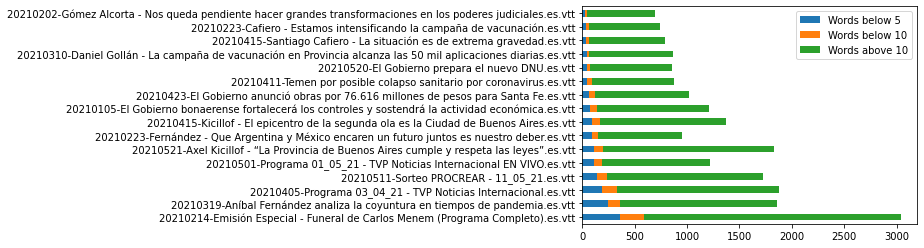

In [18]:
WORD_LIMIT_IDX = 38

words_cut: List[str] = w_index[1:WORD_LIMIT_IDX]
files_cut: FileDict = {t: f for t, f in file_texts.items() if all(map(lambda w: w in f, words_cut))}

df_vc, df_vc_percents = gen_stacked_and_perc_df(files_cut, LIMS)

print("Showing {} videos".format(len(files_cut)))
df_vc.plot.barh(stacked=True)

Showing 16 videos


<AxesSubplot:>

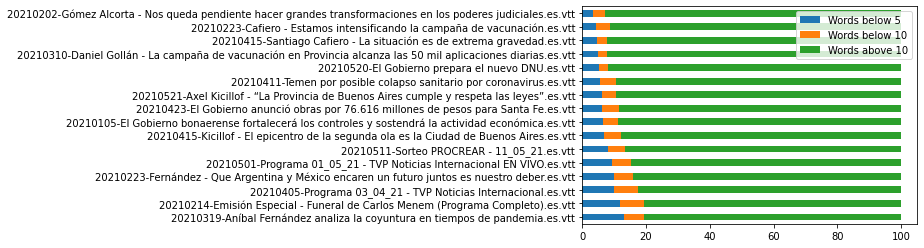

In [19]:
print("Showing {} videos".format(len(files_cut)))
df_vc_percents.plot.barh(stacked=True)

In [20]:
pos_to_percent = lambda df, f: 100 * (len(df.index) - list(df.index).index(f)) / len(df.index)

df_cut_to_tf = pd.DataFrame({
    'pos_at_token_freq': [pos_to_percent(df_videos_tokens_frequency, f) for f in files_cut],
    'pos_at_token_freq_perc': [pos_to_percent(df_vtf_percents, f) for f in files_cut]
}, index=files_cut)

display(df_cut_to_tf.head(20))

pos_at_token_freq  \
20210423-El Gobierno anunció obras por 76.616 m...          98.965446   
20210223-Fernández - Que Argentina y México enc...          99.793089   
20210214-Emisión Especial - Funeral de Carlos M...         100.000000   
20210202-Gómez Alcorta - Nos queda pendiente ha...          85.681771   
20210521-Axel Kicillof - “La Provincia de Bueno...          99.834471   
20210415-Santiago Cafiero - La situación es de ...          95.075522   
20210411-Temen por posible colapso sanitario po...          97.951583   
20210310-Daniel Gollán - La campaña de vacunaci...          96.792882   
20210105-El Gobierno bonaerense fortalecerá los...          99.503414   
20210405-Programa 03_04_21 - TVP Noticias Inter...          99.958618   
20210511-Sorteo PROCREAR - 11_05_21.es.vtt                  99.937927   
20210223-Cafiero - Estamos intensificando la ca...          93.627147   
20210319-Aníbal Fernández analiza la coyuntura ...          99.979309   
20210520-El Gobierno prepara el nuevo DNU.es.vtt            97.103248   
20210415-Kicillof - El epicentro de la segunda ...          99.772398   
20210501-Programa 01_05_21 - TVP Noticias Inter...          99.875854   

                                                    pos_at_token_freq_perc  
20210423-El Gobierno anunció obras por 76.616 m...               64.018208  
20210223-Fernández - Que Argentina y México enc...               91.909787  
20210214-Emisión Especial - Funeral de Carlos M...               96.027312  
20210202-Gómez Alcorta - Nos queda pendiente ha...               21.767018  
20210521-Axel Kicillof - “La Provincia de Bueno...               62.549141  
20210415-Santiago Cafiero - La situación es de ...               42.313263  
20210411-Temen por posible colapso sanitario po...               57.955721  
20210310-Daniel Gollán - La campaña de vacunaci...               46.554935  
20210105-El Gobierno bonaerense fortalecerá los...               67.018415  
20210405-Programa 03_04_21 - TVP Noticias Inter...               92.199462  
20210511-Sorteo PROCREAR - 11_05_21.es.vtt                       82.040141  
20210223-Cafiero - Estamos intensificando la ca...               38.423340  
20210319-Aníbal Fernández analiza la coyuntura ...               97.786054  
20210520-El Gobierno prepara el nuevo DNU.es.vtt                 50.817298  
20210415-Kicillof - El epicentro de la segunda ...               71.653217  
20210501-Programa 01_05_21 - TVP Noticias Inter...               89.633768

Histograma de frequencia de tokens de los videos seleccionados

count    9691.000000
mean        4.746569
std        15.262058
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       723.000000
dtype: float64

Mean:  4.746568981529254
Std:  15.26205751966639
/home/pedroodb/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

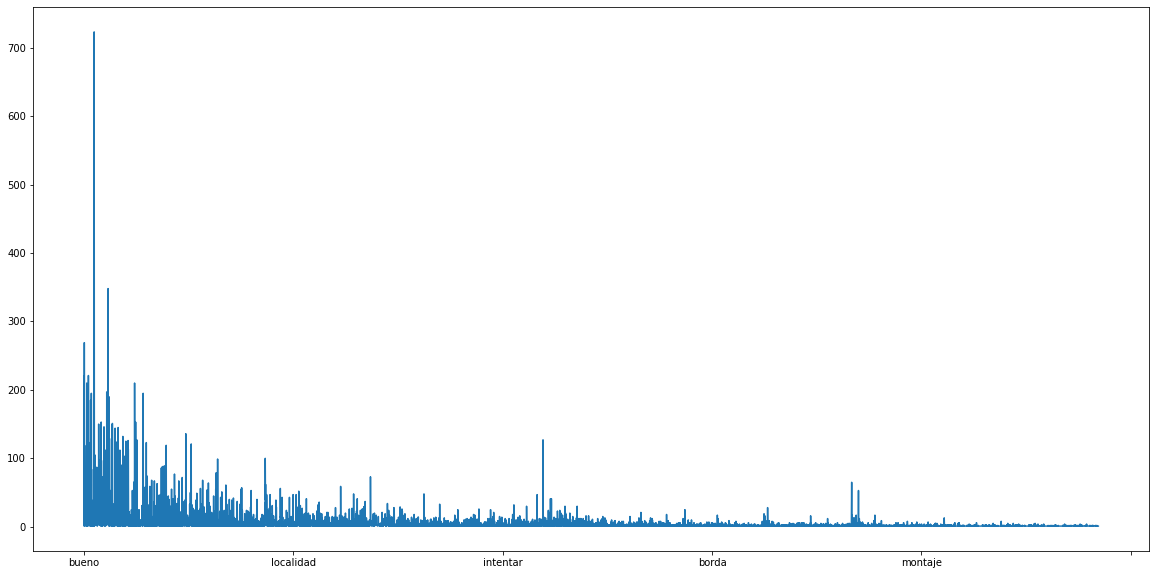

In [21]:
cut_tokens_freq = total_token_freq(files_cut)

s_cut_tokens_freq = pd.Series(cut_tokens_freq)
display(s_cut_tokens_freq.describe())
print('Mean: ', s_cut_tokens_freq.mean())
print('Std: ', s_cut_tokens_freq.std())
display(s_cut_tokens_freq.plot(figsize=(20,10)))

Histograma de frequencia de tokens de muestras aleatorias de 100 videos

In [23]:
import random

def gen_random_sample(size: int) -> Tuple[FileDict, float, TokenDict]:
    random_files = {k: v for (k,v) in random.sample(file_texts.items(), size)}
    random_len = total_time(random_files.keys(), vids_l)
    random_token_freq = total_token_freq(random_files)
    s_random_token_freq = pd.Series(random_token_freq)
    
    return {
        'series': s_random_token_freq,
        'total_len': random_len,
        'mean': s_random_token_freq.mean(),
        'std': s_random_token_freq.std()
    }

rnd_samples = [gen_random_sample(150) for _ in range(1000)]
df_rnd_samples = pd.DataFrame(rnd_samples)
df_rnd_samples.describe()

total_len         mean          std
count  1000.000000  1000.000000  1000.000000
mean     11.479081     4.699576    14.150725
std       0.991884     0.191369     0.966275
min       9.257936     4.246136    11.853981
25%      10.780291     4.567175    13.469891
50%      11.407802     4.685745    14.096308
75%      12.099687     4.823140    14.764200
max      16.428015     5.483198    18.180842